In [72]:
import sys  
sys.path.insert(0, '../')

In [73]:
import torch
import time
import numpy as np
import random
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils.convert import to_networkx
from easydict import EasyDict

import options
from rl.explore import epsilon_greedy_gc
from data.dataset import InMemorySokobanDataset
from data.graph_env import GraphEnv
from data.utils import display_graph, direction_to_node_idx
from model.graph_centered import GraphCenteredNet
from rl.qlearning_trainer_gc import QLearningGraphCenteredTrainer
from data.embedding import DirectionalPositionalEmbedding, FullyConnectedPositionalEmbedding

In [74]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
SEED = 42
TRAIN_PATH = "../levels/dummy_10/train/"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random.seed(SEED)
np.random.seed(SEED)

## Graph environment

In [52]:
embedding = DirectionalPositionalEmbedding()
dataset = InMemorySokobanDataset(TRAIN_PATH, embedding)
graph_env = GraphEnv(embedding, 'cpu')

state = dataset[0]
graph_env.reset(state)

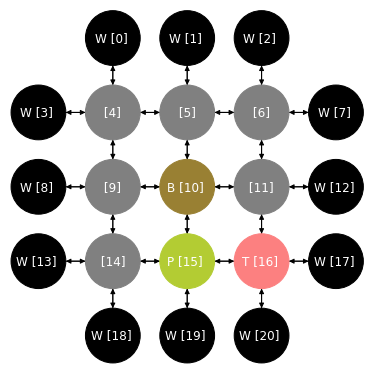

In [53]:
state = graph_env.render()
plt.figure(figsize=(5, 5))
display_graph(state)

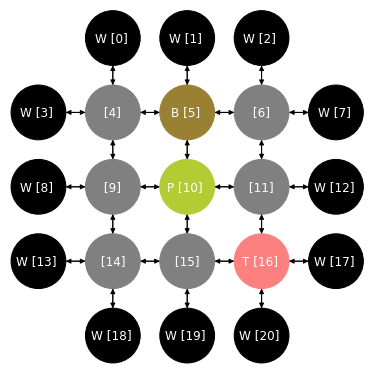

In [54]:
# Up = 0
next_state, reward, done, info = graph_env.step(
    direction_to_node_idx(state, 0)
)
state = graph_env.render()
plt.figure(figsize=(5, 5))
display_graph(state)
plt.show()

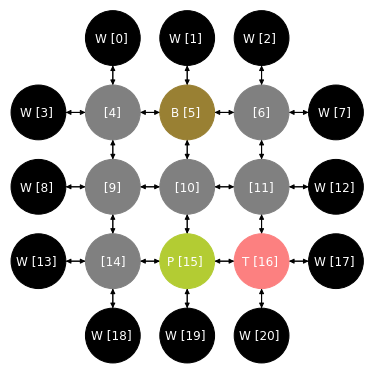

In [55]:
# Down = 1
next_state, reward, done, info = graph_env.step(
    direction_to_node_idx(state, 1)
)
state = graph_env.render()
plt.figure(figsize=(5, 5))
display_graph(state)
plt.show()

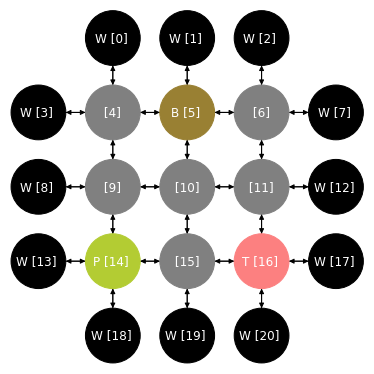

In [56]:
# Left = 2
next_state, reward, done, info = graph_env.step(
    direction_to_node_idx(state, 2)
)
state = graph_env.render()
plt.figure(figsize=(5, 5))
display_graph(state)
plt.show()

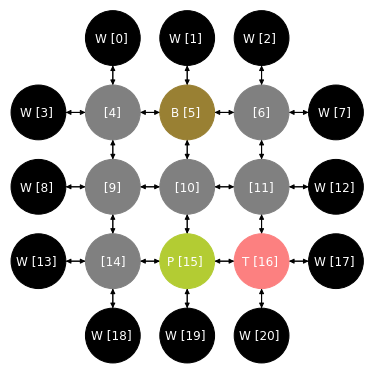

In [57]:
# Right = 3
next_state, reward, done, info = graph_env.step(
    direction_to_node_idx(state, 3)
)
state = graph_env.render()
plt.figure(figsize=(5, 5))
display_graph(state)
plt.show()

## Training

In [96]:
# Class containing all the options: only for notebook purpose, 
# otherwise contained in a parser
class Options:
    def __init__(self):
        self.train_path = "../levels/dummy_10/train"
        self.test_path = "../levels/dummy_10/test"
        self.target_update = 100
        self.gamma = 1.0
        self.eps_max = 1.0
        self.eps_min = 0.1
        self.eps_stop_step = 100000
        self.batch_size = 32
        self.buffer_size = 10000
        self.max_steps = 25
        self.max_steps_eval = 25
        self.epochs = 500
        self.seed = 123
        self.walls_prob = 0
        self.static_prob = 0
        self.lr = 0.0005
        self.rms_alpha = 0.95
        self.rms_eps = 0.01
        self.no_clamp_gradient = False
        self.early_stop_deadlocks = False
        self.no_penalize_deadlocks = True
        self.go_back_after_deadlocks = False
        self.reward_deadlocks = -1

        self.embedding = DirectionalPositionalEmbedding()
        self.training_id = str(int(time.time()))
    

opt = EasyDict(Options().__dict__)

In [97]:
trainer = QLearningGraphCenteredTrainer(opt)

PARAMETERS SUMMARY
train_path: ../levels/dummy_10/train
test_path: ../levels/dummy_10/test
target_update: 100
gamma: 1.0
eps_max: 1.0
eps_min: 0.1
eps_stop_step: 100000
batch_size: 32
buffer_size: 10000
max_steps: 25
max_steps_eval: 25
epochs: 500
seed: 123
walls_prob: 0
static_prob: 0
lr: 0.0005
rms_alpha: 0.95
rms_eps: 0.01
no_clamp_gradient: False
early_stop_deadlocks: False
no_penalize_deadlocks: True
go_back_after_deadlocks: False
reward_deadlocks: -1
embedding: <data.embedding.DirectionalPositionalEmbedding object at 0x7ff991680668>
training_id: 1578176897
====
INFO
====
train_size: 100
test_size: 1
scheduler: <class 'rl.schedulers.AnnealingScheduler'>


In [98]:
# Model for target network
print(trainer.target_net)

GraphCenteredNet(
  (conv_e): EdgeConv(nn=Sequential(
    (0): Linear(in_features=14, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
  ))
  (conv_c1): EdgeConv(nn=Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
  ))
  (conv_c2): EdgeConv(nn=Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
  ))
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)


In [99]:
monitor = ['solved', 'mean_cum_reward', 'time elapsed', 'mean_loss', 'epsilon']
history = {name: [] for name in monitor}

for epoch in range(opt.epochs):
    epoch_info = trainer.train_one_epoch()
    trainer.eval_one_epoch()
    
    for name in monitor:
        history[name].append(epoch_info[name])

print("training done in {}".format(sum(history["time elapsed"])))

EPOCH 0
mean_cum_reward[train]: -0.402
solved[train]: 16
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 1.0
time elapsed[train]: 36.9127
mean_loss[train]: 17.7837
mean_cum_reward[eval]: -1.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 1
mean_cum_reward[train]: -0.655
solved[train]: 15
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.9796
time elapsed[train]: 38.3185
mean_loss[train]: 16.5258
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 2
mean_cum_reward[train]: -0.621
solved[train]: 15
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.9588
time elapsed[train]: 40.2002
mean_loss[train]: 15.6598
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 3
mean_cum_reward[train]: -0.792
solved[train]: 14
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.9384
time elapsed[train]: 41.4775
mean_loss[train]: 15.4723
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 4
mean_cum_re

mean_cum_reward[train]: -0.886
solved[train]: 13
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.505
time elapsed[train]: 44.2577
mean_loss[train]: 13.1824
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 25
mean_cum_reward[train]: -1.162
solved[train]: 11
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.4842
time elapsed[train]: 45.8447
mean_loss[train]: 12.6672
mean_cum_reward[eval]: -1.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 26
mean_cum_reward[train]: -1.373
solved[train]: 9
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.4628
time elapsed[train]: 45.2512
mean_loss[train]: 12.3861
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 27
mean_cum_reward[train]: -0.992
solved[train]: 12
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.4416
time elapsed[train]: 44.6884
mean_loss[train]: 11.9306
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 28
mean_cum_rewar

mean_cum_reward[train]: 1.405
solved[train]: 31
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 41.652
mean_loss[train]: 5.835
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 49
mean_cum_reward[train]: 0.522
solved[train]: 24
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 44.2218
mean_loss[train]: 5.9875
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 50
mean_cum_reward[train]: 1.003
solved[train]: 27
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 43.1754
mean_loss[train]: 6.0371
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 51
mean_cum_reward[train]: -0.004
solved[train]: 20
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 45.8799
mean_loss[train]: 6.2568
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 52
mean_cum_reward[train]: -0.888
so

mean_cum_reward[train]: -0.062
solved[train]: 20
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 47.2721
mean_loss[train]: 5.0719
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 73
mean_cum_reward[train]: -0.482
solved[train]: 16
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 46.6367
mean_loss[train]: 4.4078
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 74
mean_cum_reward[train]: 0.114
solved[train]: 21
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 45.5088
mean_loss[train]: 4.0234
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 75
mean_cum_reward[train]: 0.436
solved[train]: 23
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 43.3157
mean_loss[train]: 3.5317
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 76
mean_cum_reward[train]: -0.579

mean_cum_reward[train]: 3.642
solved[train]: 46
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 36.186
mean_loss[train]: 2.0975
mean_cum_reward[eval]: -1.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 97
mean_cum_reward[train]: 3.376
solved[train]: 45
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 34.8327
mean_loss[train]: 2.0356
mean_cum_reward[eval]: -1.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 98
mean_cum_reward[train]: 3.559
solved[train]: 46
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 35.8322
mean_loss[train]: 2.0892
mean_cum_reward[eval]: -1.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 99
mean_cum_reward[train]: 1.177
solved[train]: 30
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 44.0327
mean_loss[train]: 2.517
mean_cum_reward[eval]: -1.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 100
mean_cum_reward[train]: -0.446
so

mean_cum_reward[train]: -1.367
solved[train]: 9
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 48.8506
mean_loss[train]: 0.5874
mean_cum_reward[eval]: -1.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 121
mean_cum_reward[train]: -1.344
solved[train]: 9
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 48.0254
mean_loss[train]: 0.6844
mean_cum_reward[eval]: -1.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 122
mean_cum_reward[train]: -1.84
solved[train]: 5
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 49.193
mean_loss[train]: 0.7334
mean_cum_reward[eval]: -1.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 123
mean_cum_reward[train]: -1.358
solved[train]: 9
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 48.4538
mean_loss[train]: 0.834
mean_cum_reward[eval]: -1.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 124
mean_cum_reward[train]: -1.352


mean_cum_reward[train]: 0.708
solved[train]: 25
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 42.4237
mean_loss[train]: 0.2223
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 145
mean_cum_reward[train]: 1.248
solved[train]: 29
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 42.5236
mean_loss[train]: 0.1874
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 146
mean_cum_reward[train]: 0.661
solved[train]: 25
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 43.2831
mean_loss[train]: 0.1717
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 147
mean_cum_reward[train]: 1.418
solved[train]: 30
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 41.8326
mean_loss[train]: 0.1715
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 148
mean_cum_reward[train]: 0.39

mean_cum_reward[train]: 1.517
solved[train]: 31
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 39.3503
mean_loss[train]: 0.087
mean_cum_reward[eval]: -1.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 169
mean_cum_reward[train]: 1.439
solved[train]: 31
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 40.7725
mean_loss[train]: 0.0998
mean_cum_reward[eval]: -1.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 170
mean_cum_reward[train]: 1.032
solved[train]: 28
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 42.5895
mean_loss[train]: 0.1042
mean_cum_reward[eval]: -1.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 171
mean_cum_reward[train]: 1.391
solved[train]: 30
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 39.723
mean_loss[train]: 0.0899
mean_cum_reward[eval]: -1.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 172
mean_cum_reward[train]: 1.614


mean_cum_reward[train]: 4.439
solved[train]: 54
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 31.0395
mean_loss[train]: 0.0339
mean_cum_reward[eval]: -1.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 193
mean_cum_reward[train]: 4.333
solved[train]: 53
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 30.9489
mean_loss[train]: 0.0355
mean_cum_reward[eval]: -1.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 194
mean_cum_reward[train]: 5.042
solved[train]: 58
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 27.8303
mean_loss[train]: 0.0299
mean_cum_reward[eval]: -1.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 195
mean_cum_reward[train]: 4.634
solved[train]: 55
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 29.2674
mean_loss[train]: 0.0287
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 196
mean_cum_reward[train]: 4.87

mean_cum_reward[train]: 7.75
solved[train]: 80
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 21.8826
mean_loss[train]: 0.0185
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 217
mean_cum_reward[train]: 7.66
solved[train]: 78
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 21.3879
mean_loss[train]: 0.0166
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 218
mean_cum_reward[train]: 7.706
solved[train]: 79
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 20.3116
mean_loss[train]: 0.0129
mean_cum_reward[eval]: -1.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 219
mean_cum_reward[train]: 8.172
solved[train]: 82
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 19.8617
mean_loss[train]: 0.014
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 220
mean_cum_reward[train]: 8.729
s

mean_cum_reward[train]: 9.492
solved[train]: 93
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 15.3328
mean_loss[train]: 0.0156
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 241
mean_cum_reward[train]: 9.794
solved[train]: 94
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 13.7741
mean_loss[train]: 0.015
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 242
mean_cum_reward[train]: 10.293
solved[train]: 99
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 12.3072
mean_loss[train]: 0.0113
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 243
mean_cum_reward[train]: 9.476
solved[train]: 92
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 15.6124
mean_loss[train]: 0.0129
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 244
mean_cum_reward[train]: 9.98

mean_cum_reward[train]: 10.407
solved[train]: 100
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 12.129
mean_loss[train]: 0.0083
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 265
mean_cum_reward[train]: 10.19
solved[train]: 98
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 12.3084
mean_loss[train]: 0.0084
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 266
mean_cum_reward[train]: 10.043
solved[train]: 97
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 12.877
mean_loss[train]: 0.0087
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 267
mean_cum_reward[train]: 10.288
solved[train]: 99
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 12.239
mean_loss[train]: 0.0078
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 268
mean_cum_reward[train]: 10.

mean_cum_reward[train]: 10.283
solved[train]: 99
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 12.7358
mean_loss[train]: 0.0067
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 289
mean_cum_reward[train]: 10.41
solved[train]: 100
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 12.2586
mean_loss[train]: 0.006
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 290
mean_cum_reward[train]: 9.885
solved[train]: 96
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 14.064
mean_loss[train]: 0.0071
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 291
mean_cum_reward[train]: 9.636
solved[train]: 94
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 14.4023
mean_loss[train]: 0.0075
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 292
mean_cum_reward[train]: 9.75

mean_cum_reward[train]: 10.038
solved[train]: 97
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 13.0186
mean_loss[train]: 0.0076
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 313
mean_cum_reward[train]: 10.164
solved[train]: 97
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 12.6163
mean_loss[train]: 0.0085
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 314
mean_cum_reward[train]: 10.257
solved[train]: 99
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 13.1273
mean_loss[train]: 0.0089
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 315
mean_cum_reward[train]: 10.189
solved[train]: 98
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 12.072
mean_loss[train]: 0.0071
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 316
mean_cum_reward[train]: 1

mean_cum_reward[train]: 10.009
solved[train]: 97
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 13.6182
mean_loss[train]: 0.0068
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 337
mean_cum_reward[train]: 9.767
solved[train]: 95
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 14.1982
mean_loss[train]: 0.0079
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 338
mean_cum_reward[train]: 9.74
solved[train]: 93
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 14.7302
mean_loss[train]: 0.0122
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 339
mean_cum_reward[train]: 9.679
solved[train]: 94
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 15.9454
mean_loss[train]: 0.0201
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 340
mean_cum_reward[train]: 9.70

mean_cum_reward[train]: 10.178
solved[train]: 98
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 12.4261
mean_loss[train]: 0.0043
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 361
mean_cum_reward[train]: 10.04
solved[train]: 97
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 13.0323
mean_loss[train]: 0.0045
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 362
mean_cum_reward[train]: 10.432
solved[train]: 100
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 11.8194
mean_loss[train]: 0.005
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 363
mean_cum_reward[train]: 10.152
solved[train]: 98
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 13.0031
mean_loss[train]: 0.0052
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 364
mean_cum_reward[train]: 1

mean_cum_reward[train]: 10.165
solved[train]: 98
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 12.5707
mean_loss[train]: 0.0066
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 385
mean_cum_reward[train]: 10.142
solved[train]: 98
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 13.1484
mean_loss[train]: 0.0087
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 386
mean_cum_reward[train]: 10.295
solved[train]: 99
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 12.2199
mean_loss[train]: 0.0086
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 387
mean_cum_reward[train]: 10.262
solved[train]: 98
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 13.1449
mean_loss[train]: 0.0072
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 388
mean_cum_reward[train]: 

mean_cum_reward[train]: 9.753
solved[train]: 95
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 14.3076
mean_loss[train]: 0.0068
mean_cum_reward[eval]: -1.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 409
mean_cum_reward[train]: 10.127
solved[train]: 98
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 13.61
mean_loss[train]: 0.0062
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 410
mean_cum_reward[train]: 10.161
solved[train]: 98
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 12.7618
mean_loss[train]: 0.0059
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 411
mean_cum_reward[train]: 10.173
solved[train]: 98
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 12.5456
mean_loss[train]: 0.0055
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 412
mean_cum_reward[train]: 10.

mean_cum_reward[train]: 9.108
solved[train]: 90
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 16.4119
mean_loss[train]: 0.0059
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 433
mean_cum_reward[train]: 10.079
solved[train]: 98
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 14.5013
mean_loss[train]: 0.0072
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 434
mean_cum_reward[train]: 10.013
solved[train]: 97
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 13.5916
mean_loss[train]: 0.0066
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 435
mean_cum_reward[train]: 9.942
solved[train]: 97
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 14.8991
mean_loss[train]: 0.0074
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 436
mean_cum_reward[train]: 10

mean_cum_reward[train]: 9.465
solved[train]: 93
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 15.8024
mean_loss[train]: 0.0134
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 457
mean_cum_reward[train]: 9.71
solved[train]: 95
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 15.254
mean_loss[train]: 0.0191
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 458
mean_cum_reward[train]: 9.892
solved[train]: 96
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 13.9778
mean_loss[train]: 0.0108
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 459
mean_cum_reward[train]: 9.345
solved[train]: 92
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 16.0796
mean_loss[train]: 0.0131
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 460
mean_cum_reward[train]: 9.457


mean_cum_reward[train]: 8.884
solved[train]: 88
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 18.7179
mean_loss[train]: 0.0114
mean_cum_reward[eval]: -1.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 481
mean_cum_reward[train]: 9.171
solved[train]: 91
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 17.4735
mean_loss[train]: 0.0118
mean_cum_reward[eval]: -1.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 482
mean_cum_reward[train]: 10.282
solved[train]: 99
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 12.5696
mean_loss[train]: 0.0075
mean_cum_reward[eval]: -2.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 483
mean_cum_reward[train]: 9.992
solved[train]: 96
deadlocks[train]: 0
dataset size[train]: 100
epsilon[train]: 0.1
time elapsed[train]: 14.2066
mean_loss[train]: 0.0072
mean_cum_reward[eval]: -1.5
solved[eval]: 0
dataset size[eval]: 1
EPOCH 484
mean_cum_reward[train]: 9.8

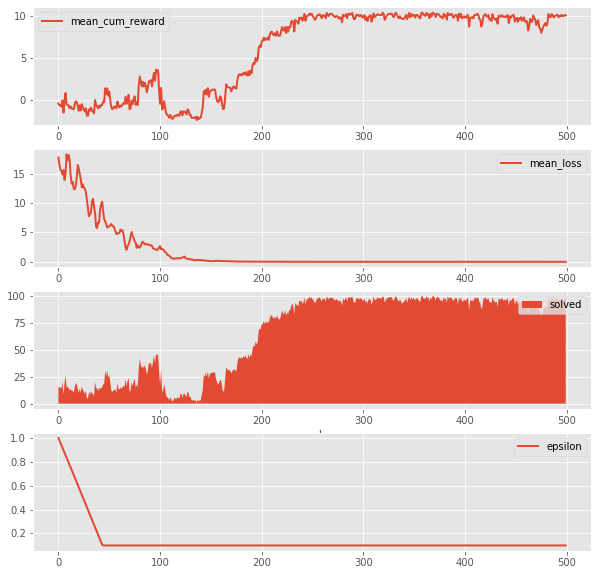

In [110]:
plt.style.use('ggplot')

fig, axes = plt.subplots(4, 1, figsize=(10, 10))
axes[0].plot(history["mean_cum_reward"], lw=2, label='mean_cum_reward')
axes[0].legend()
axes[1].plot(history["mean_loss"], lw=2, label='mean_loss')
axes[1].legend()
axes[2].fill_between(range(opt.epochs), history["solved"], lw=2, label='solved')
axes[2].set_xlabel('epochs')
axes[2].legend()
axes[3].plot(history["epsilon"], lw=2, label='epsilon')
axes[3].legend()

plt.show()

## Behavior of the trained model

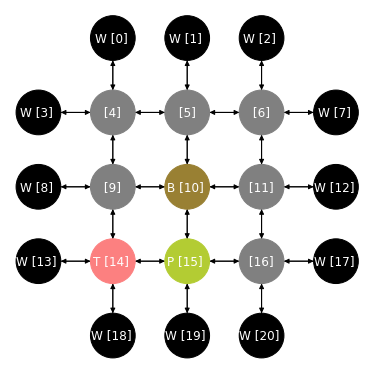

right
16


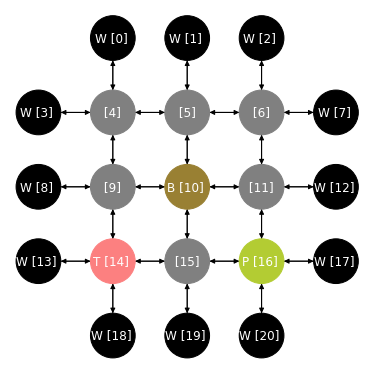

up
11


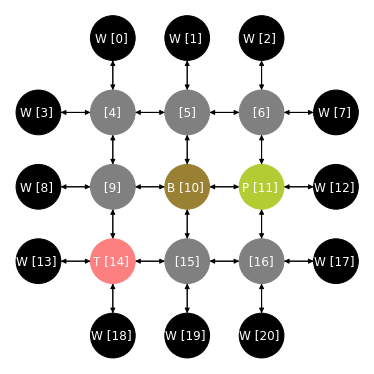

left
10


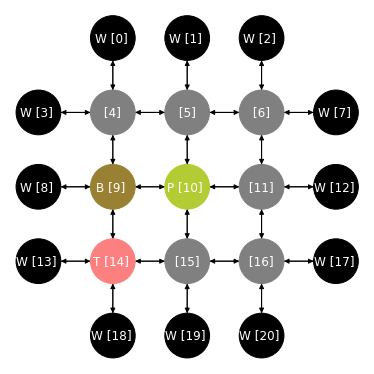

up
5


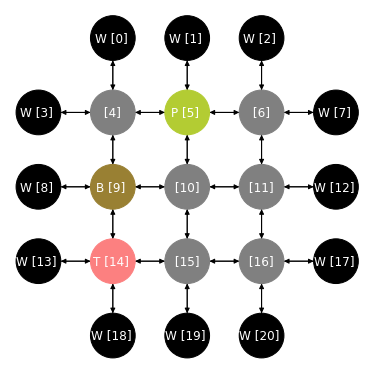

left
4


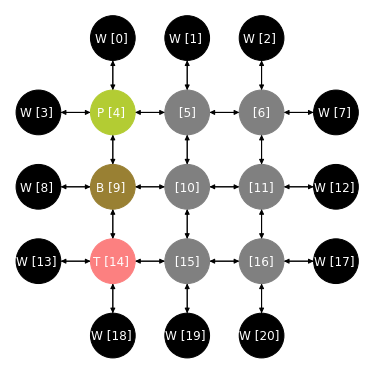

down
9


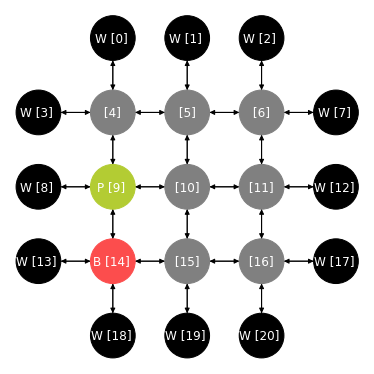

left
8


In [104]:
actions = {0: 'up', 1: 'down', 2: 'left', 3: 'right'}

with torch.no_grad():
    # Initialize the environment and state
    trainer.env.reset(trainer.dataset_train[4])
    
    for t in range(trainer.opt.max_steps_eval):
        state = trainer.env.render()
        
        # Plot the state
        plt.figure(figsize=(5, 5))
        display_graph(state, node_size=2000)
        plt.show()
        
        # Select and perform an action
        action = epsilon_greedy_gc(
            state, trainer.policy_net, 0, device=trainer.device
        )
        
        print(actions[action.item()])
        action_node = direction_to_node_idx(state, action)
        print(action_node.item())
        
        # Observe new state
        next_state, reward, done, info = trainer.env.step(action_node)
        
        if done:
            break